# Import the necessary libraries and data

In [2]:
import pandas as pd
match = pd.read_csv('Match Info.csv', encoding='latin1') 
player = pd.read_csv('Player Info.csv', encoding='latin1')
team = pd.read_csv('Team Info.csv', encoding='latin1')

match.info()
team.info()
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           25979 non-null  object
 1   League            25979 non-null  object
 2   Season            25979 non-null  object
 3   Stage             25979 non-null  int64 
 4   Date              25979 non-null  object
 5   Match API ID      25979 non-null  int64 
 6   Home Team API ID  25979 non-null  int64 
 7   Away Team API ID  25979 non-null  int64 
 8   Home Team Goal    25979 non-null  int64 
 9   Away  Team Goal   25979 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 2.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Team API ID               1458 non-null   int64 
 1   Team FIFA API I

# 1. Match tables
# a. Predict the match outcome

Epoch 1/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7311 - loss: 0.5755 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 2/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9948 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 3.2880e-04
Epoch 3/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 1.2874e-04
Epoch 4/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 5.0611e-05
Epoch 5/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 9.9384e-04 - val_accuracy: 1.0000 - val_loss: 2.8299e-05
Epoch 6/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 4.9013e-05
Epoch 7/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9998 - loss: 6.7345e-04 - val_accuracy: 1.0000 - val_loss: 1.1141e-05
Epoch 8/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 

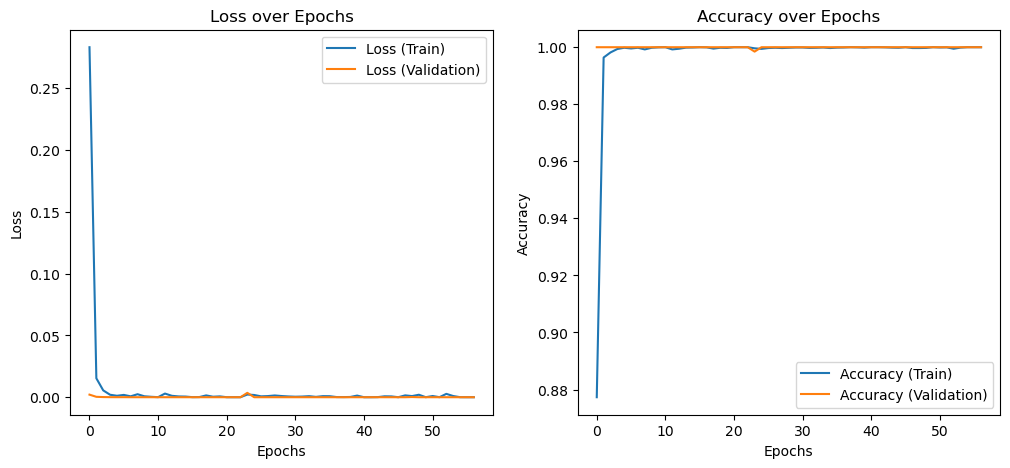

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Assume df_match is a DataFrame containing match data
df_match = match.copy()

# Preprocess the data
df_match['Result'] = np.where(df_match['Home Team Goal'] > df_match['Away  Team Goal'], 'Win', 
                               np.where(df_match['Home Team Goal'] < df_match['Away  Team Goal'], 'Lose', 'Draw'))

# Select feature and label columns
X = df_match[['Home Team Goal', 'Away  Team Goal', 'Stage']]  # Ví dụ
y = df_match['Result']

# Convert labels to numerical values
y = pd.get_dummies(y)

# Apply One-Hot Encoding to the 'Stage' column if it is categorical
X = pd.get_dummies(X, columns=['Stage'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))  # Tăng số nơ-ron
model.add(Dropout(0.3))  # Thêm lớp Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Thêm lớp Dropout
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))  # Số lớp đầu ra

# Tune the learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_match_result_model.keras', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, model_checkpoint])  # Sử dụng callbacks

# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model
model.save('final_match_result_model.keras')


# b. Predict the number of goals

Epoch 1/300
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4485 - mean_absolute_error: 0.4952 - val_loss: 0.0888 - val_mean_absolute_error: 0.2193 - learning_rate: 0.0010
Epoch 2/300
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0747 - mean_absolute_error: 0.2061 - val_loss: 0.1321 - val_mean_absolute_error: 0.2691 - learning_rate: 0.0010
Epoch 3/300
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0461 - mean_absolute_error: 0.1580 - val_loss: 0.1000 - val_mean_absolute_error: 0.2330 - learning_rate: 0.0010
Epoch 4/300
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0335 - mean_absolute_error: 0.1306 - val_loss: 0.1382 - val_mean_absolute_error: 0.2640 - learning_rate: 0.0010
Epoch 5/300
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0287 - mean_absolute_error: 0.1176 - val_loss: 0.1529 - val_mean_absolute_error: 0.2865 - learning_rate: 0.0010
Epoch 6/300
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0232 - mean_absolute_error: 0.1052 - val_loss: 0.1316 - val_me

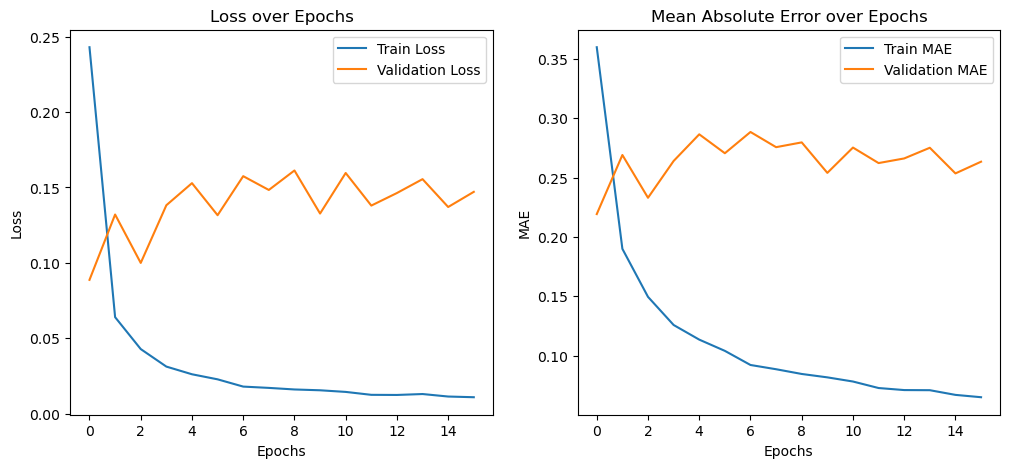

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

# Assume df_match is a DataFrame containing the uploaded match data
df_match = match.copy()

# Feature Engineering
df_match['Goal Difference'] = df_match['Home Team Goal'] - df_match['Away  Team Goal']
X_goals = df_match[['Stage', 'Home Team Goal', 'Away  Team Goal', 'Goal Difference']]
y_goals = df_match['Home Team Goal']

# Apply One-Hot Encoding for categorical variables
X_goals = pd.get_dummies(X_goals, columns=['Stage'], drop_first=True)

# Normalize the data
scaler_X = StandardScaler()
X_goals_scaled = scaler_X.fit_transform(X_goals)

# Normalize y to improve model convergence
scaler_y = StandardScaler()
y_goals_scaled = scaler_y.fit_transform(y_goals.values.reshape(-1, 1)).ravel()

# Split the data
X_train_goals, X_test_goals, y_train_goals, y_test_goals = train_test_split(
    X_goals_scaled, y_goals_scaled, test_size=0.2, random_state=42
)

# Build a regression model
model_goals = Sequential()
model_goals.add(Dense(128, activation='relu', input_shape=(X_train_goals.shape[1],)))
model_goals.add(Dropout(0.4))  # Set a higher dropout rate to minimize overfitting
model_goals.add(Dense(64, activation='relu'))
model_goals.add(Dropout(0.4))
model_goals.add(Dense(32, activation='relu'))
model_goals.add(Dense(1))  # The output is the number of goals

# Make the learning rate a tunable parameter with ReduceLROnPlateau
model_goals.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Advanced callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_goal_prediction_model.keras', save_best_only=True)

# Train the model
history = model_goals.fit(
    X_train_goals, y_train_goals,
    epochs=300,
    batch_size=32,
    validation_data=(X_test_goals, y_test_goals),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Convert the predicted values back to their original form
y_test_pred = scaler_y.inverse_transform(model_goals.predict(X_test_goals))

# Save the final model
model_goals.save('final_goal_prediction_model.keras')


# 2. Team tables
# a. Classification and clustering

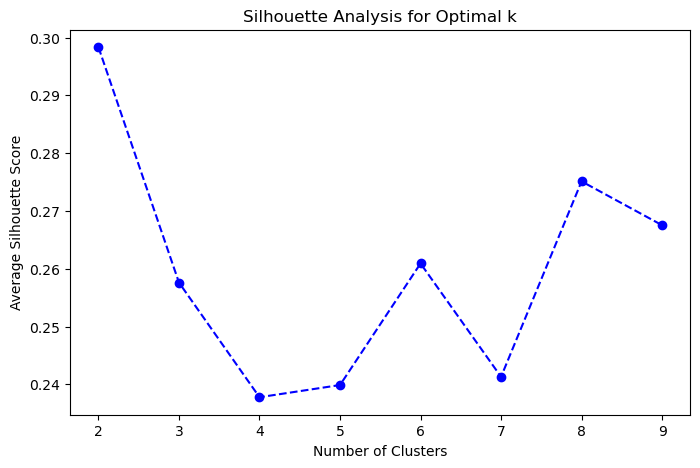

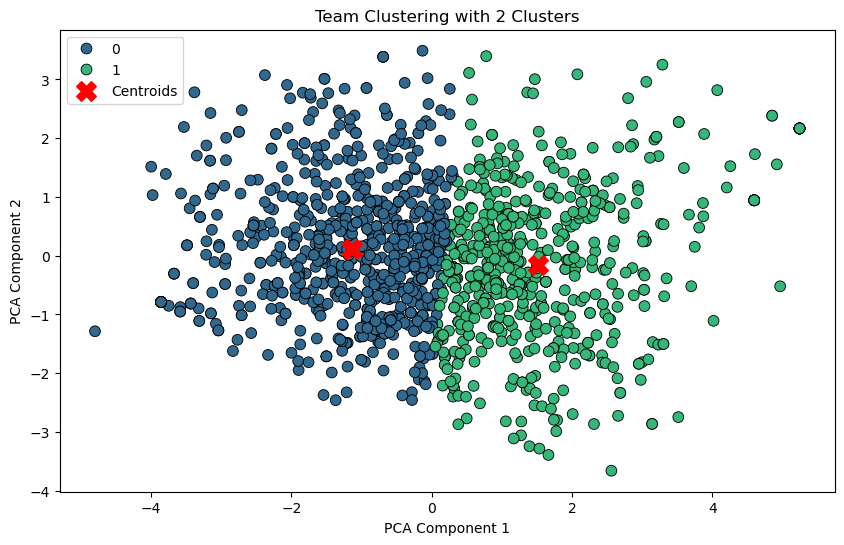

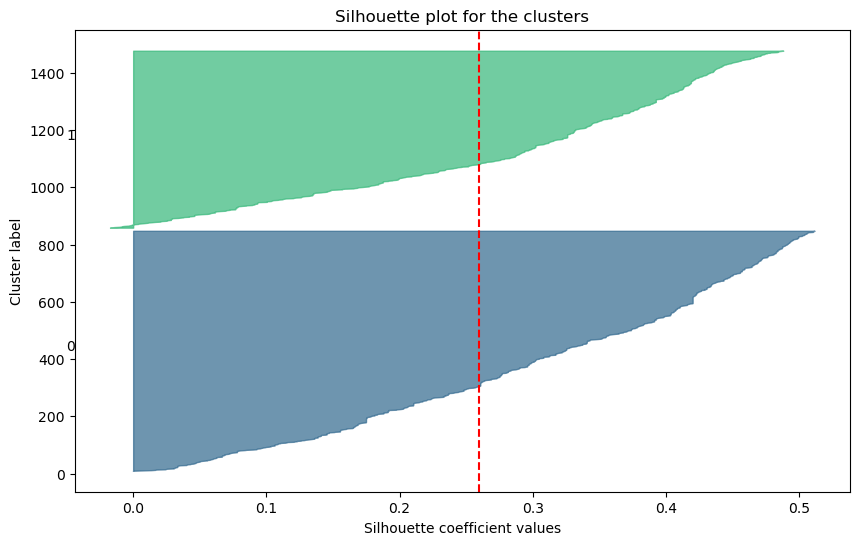

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Assume df_team is a DataFrame containing the uploaded team data
df_team = team.copy()

# Feature Engineering: Add some additional features
df_team['Play Speed Passing'] = df_team['Build Up Play Speed'] * df_team['Build Up Play Passing']
df_team['Pressure Passing'] = df_team['Defence Pressure'] * df_team['Build Up Play Passing']
X_team = df_team[['Build Up Play Speed', 'Build Up Play Passing', 'Defence Pressure', 
                  'Play Speed Passing', 'Pressure Passing']]

# Normalize the data
scaler = StandardScaler()
X_team_scaled = scaler.fit_transform(X_team)

# Find the optimal number of clusters using Silhouette Analysis
silhouette_avg_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_team_scaled)
    silhouette_avg = silhouette_score(X_team_scaled, labels)
    silhouette_avg_scores.append(silhouette_avg)

# Plot the Silhouette graph to select the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_avg_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Apply KMeans with the optimal number of clusters (assuming k=3 based on Silhouette Analysis)
optimal_k = silhouette_avg_scores.index(max(silhouette_avg_scores)) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_team['Cluster'] = kmeans.fit_predict(X_team_scaled)

# Reduce the data dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_team_pca = pca.fit_transform(X_team_scaled)
df_team['PCA1'] = X_team_pca[:, 0]
df_team['PCA2'] = X_team_pca[:, 1]

# Visualization: Plot the PCA-reduced clusters with centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=df_team, palette='viridis', s=60, edgecolor='k'
)
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroids'
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'Team Clustering with {optimal_k} Clusters')
plt.legend()
plt.show()

# Display a detailed Silhouette plot for the optimal number of clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sample_silhouette_values = silhouette_samples(X_team_scaled, df_team['Cluster'])
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[df_team['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = sns.color_palette('viridis', optimal_k)[i]
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette plot for the clusters")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
plt.axvline(x=np.mean(silhouette_avg_scores), color="red", linestyle="--")
plt.show()


# b. Predict the performance of Chance Creation Shooting

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2876.0664 - val_loss: 1682.2104 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1004.4318 - val_loss: 334.0177 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 337.8999 - val_loss: 215.3405 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 225.3304 - val_loss: 155.7816 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 180.4362 - val_loss: 132.1136 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 179.0204 - val_loss: 114.3333 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 153.3025 - val_loss: 123.2930 - learning_rate: 0.0010
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 157.3091 - val_loss: 104.1158 - learning_rate: 0.0010
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141.4231 - val_loss: 105.1338 - l

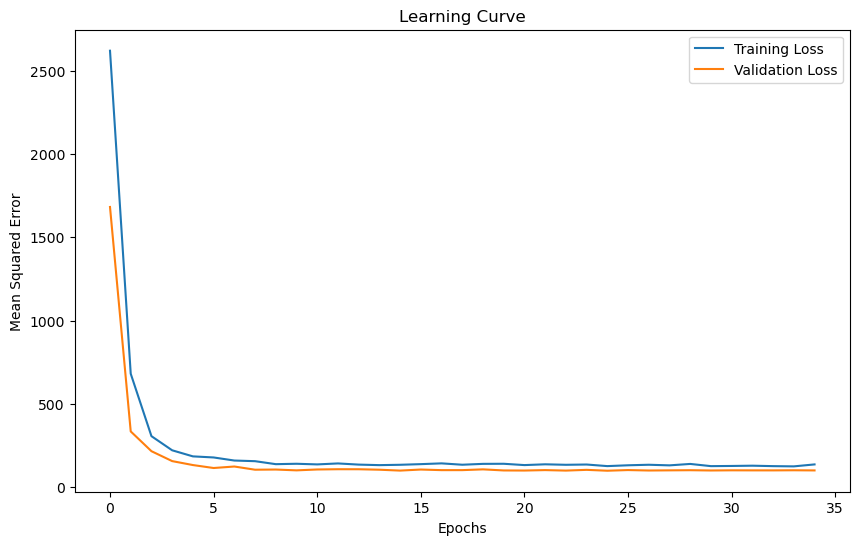

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import warnings
warnings.filterwarnings('ignore')

# Assume df_team is a DataFrame that contains team data
df_team = team.copy()

# Feature Engineering: Add interactions between features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_performance = df_team[['Build Up Play Passing', 'Defence Pressure']]
X_performance_poly = poly.fit_transform(X_performance)
y_performance = df_team['Chance Creation Shooting']

# Normalize the data
scaler = StandardScaler()
X_performance_scaled = scaler.fit_transform(X_performance_poly)

# Split the data into training and testing sets
X_train_perf, X_test_perf, y_train_perf, y_test_perf = train_test_split(
    X_performance_scaled, y_performance, test_size=0.2, random_state=42
)

# Learning rate adjustment function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Build a model with Dropout and Learning Rate Scheduler
model_performance = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_perf.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model_performance.compile(optimizer='adam', loss='mean_squared_error')

# Use Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with validation data
history = model_performance.fit(
    X_train_perf, y_train_perf, epochs=100, batch_size=16,
    validation_split=0.2, callbacks=[early_stopping, lr_scheduler], verbose=1
)

# Evaluate the model on the testing set
y_pred_perf = model_performance.predict(X_test_perf)
rmse = np.sqrt(mean_squared_error(y_test_perf, y_pred_perf))
mae = mean_absolute_error(y_test_perf, y_pred_perf)
r2 = r2_score(y_test_perf, y_pred_perf)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for train_index, val_index in kfold.split(X_performance_scaled):
    X_train_kf, X_val_kf = X_performance_scaled[train_index], X_performance_scaled[val_index]
    y_train_kf, y_val_kf = y_performance.iloc[train_index], y_performance.iloc[val_index]
    
    model_kf = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_kf.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_kf.compile(optimizer='adam', loss='mean_squared_error')
    model_kf.fit(X_train_kf, y_train_kf, epochs=100, batch_size=16,
                 validation_data=(X_val_kf, y_val_kf), callbacks=[early_stopping, lr_scheduler], verbose=0)
    
    y_val_pred = model_kf.predict(X_val_kf)
    fold_rmse = np.sqrt(mean_squared_error(y_val_kf, y_val_pred))
    fold_scores.append(fold_rmse)

print(f'Cross-Validated RMSE: {np.mean(fold_scores):.2f} ± {np.std(fold_scores):.2f}')

# Save the trained model
model_performance.save('team_performance_model_optimized.keras')

# Plot the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


# 3. Player tables
# a. Predict player performance

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 4529.1865 - val_loss: 3856.4744
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3413.5957 - val_loss: 1940.4176
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1494.6230 - val_loss: 454.2744
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 325.1945 - val_loss: 64.1340
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 83.1403 - val_loss: 29.9082
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 61.7825 - val_loss: 27.7339
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 58.0135 - val_loss: 27.8397
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 58.5783 - val_loss: 27.6794
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 55.4534 - val_loss: 27.4018
Epoch 10/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 54.7824 - val_loss: 28.0590
Epoch 11/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55.5329 - val_loss: 27.9589
Epoch 1

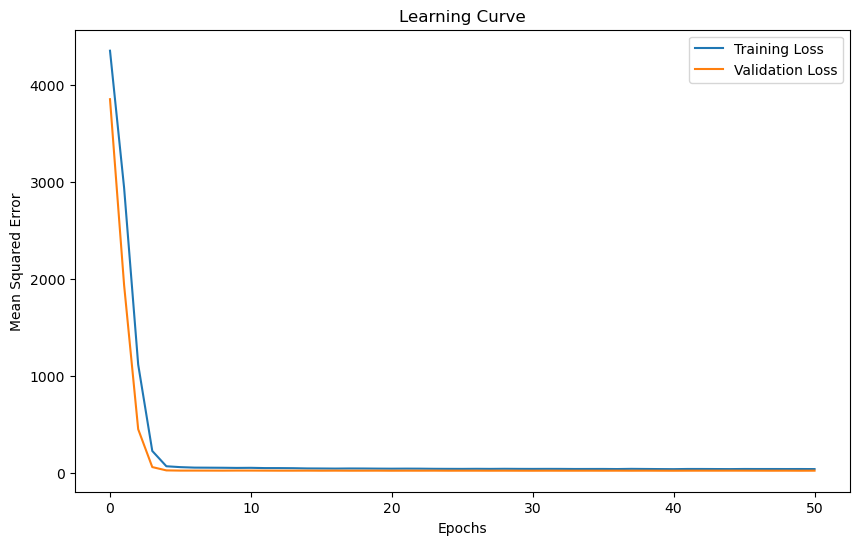

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Assume df_player is a DataFrame that contains player data
df_player = player.copy()

# Select feature columns and label
X_player = df_player[['Height', 'Weight', 'Dribbling', 'Finishing']]
y_player = df_player['Overall Rating']

# Normalize the data
scaler = StandardScaler()
X_player_scaled = scaler.fit_transform(X_player)

# Split the data into training and testing sets
X_train_player, X_test_player, y_train_player, y_test_player = train_test_split(
    X_player_scaled, y_player, test_size=0.2, random_state=42
)

# Early stopping callback if no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_player_rating_model.keras', monitor='val_loss', save_best_only=True)

# Build a model with a smaller size
model_player = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_player.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with Mean Squared Error and Adam Optimizer
model_player.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with validation data and callbacks
history = model_player.fit(
    X_train_player, y_train_player, epochs=100, batch_size=32,
    validation_split=0.2, callbacks=[early_stopping, checkpoint], verbose=1
)

# Evaluate the model on the testing set
best_model = tf.keras.models.load_model('best_player_rating_model.keras')
y_pred_player = best_model.predict(X_test_player)
rmse = np.sqrt(mean_squared_error(y_test_player, y_pred_player))
mae = mean_absolute_error(y_test_player, y_pred_player)
r2 = r2_score(y_test_player, y_pred_player)

print(f'Best Model RMSE: {rmse:.2f}')
print(f'Best Model MAE: {mae:.2f}')
print(f'Best Model R²: {r2:.2f}')

# K-Fold Cross-Validation (reduce the number of folds to increase speed)
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
fold_scores = []

for train_index, val_index in kfold.split(X_player_scaled):
    X_train_kf, X_val_kf = X_player_scaled[train_index], X_player_scaled[val_index]
    y_train_kf, y_val_kf = y_player.iloc[train_index], y_player.iloc[val_index]
    
    model_kf = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_kf.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    model_kf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    model_kf.fit(X_train_kf, y_train_kf, epochs=100, batch_size=32,
                 validation_data=(X_val_kf, y_val_kf), callbacks=[early_stopping, checkpoint], verbose=0)
    
    y_val_pred = model_kf.predict(X_val_kf)
    fold_rmse = np.sqrt(mean_squared_error(y_val_kf, y_val_pred))
    fold_scores.append(fold_rmse)

print(f'Cross-Validated RMSE: {np.mean(fold_scores):.2f} ± {np.std(fold_scores):.2f}')

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


# b. Analyze player style based on the metrics 'Dribbling', 'Finishing', and 'Shot Power'

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# Copy the original DataFrame
df_player = player.copy()

# Select the necessary metrics and handle missing values by replacing them with the median
features = df_player[['Dribbling', 'Finishing', 'Shot Power']].fillna(df_player[['Dribbling', 'Finishing', 'Shot Power']].median())

# Apply StandardScaler and RobustScaler to compare the effects of the scalers
scalers = {'StandardScaler': StandardScaler(), 'RobustScaler': RobustScaler()}
scaled_features = {}

for scaler_name, scaler in scalers.items():
    scaled = scaler.fit_transform(features)
    scaled_features[scaler_name] = pd.DataFrame(scaled, columns=features.columns)

# Combine the normalized data with player information and compare the scaling methods
df_scaled_players = {}
for scaler_name, scaled_df in scaled_features.items():
    df_scaled_players[scaler_name] = pd.concat(
        [df_player[['Player Name', 'Player FIFA API ID']].reset_index(drop=True), scaled_df], axis=1
    )
    # Assign scaler names to the columns for easy differentiation
    df_scaled_players[scaler_name].columns = ['Player Name', 'Player FIFA API ID'] + [f"{col}_{scaler_name}" for col in features.columns]

# Display the results of StandardScaler and RobustScaler for comparison
print("StandardScaler:\n", df_scaled_players['StandardScaler'].head())
print("\nRobustScaler:\n", df_scaled_players['RobustScaler'].head())


StandardScaler:
          Player Name  Player FIFA API ID  Dribbling_StandardScaler  \
0       Lionel Messi              158023                  2.151990   
1  Cristiano Ronaldo               20801                  1.983317   
2       Manuel Neuer              167495                 -2.345949   
3             Neymar              190871                  2.039541   
4        Luis Suarez              176580                  1.702196   

   Finishing_StandardScaler  Shot Power_StandardScaler  
0                  2.362862                   1.158766  
1                  2.468231                   2.008809  
2                 -1.851885                  -2.180688  
3                  2.099440                   1.037331  
4                  2.204809                   1.644505  

RobustScaler:
          Player Name  Player FIFA API ID  Dribbling_RobustScaler  \
0       Lionel Messi              158023                    1.70   
1  Cristiano Ronaldo               20801                    1.55   


Thống kê mô tả:
           Dribbling     Finishing    Shot Power
count  1.106400e+04  1.106400e+04  1.106400e+04
mean   1.541307e-16  1.233046e-16  1.233046e-16
std    1.000045e+00  1.000045e+00  1.000045e+00
min   -3.245537e+00 -2.536781e+00 -3.698621e+00
25%   -4.343251e-01 -7.981981e-01 -4.198848e-01
50%    2.403657e-01  1.501199e-01  2.480060e-01
75%    6.901595e-01  8.350162e-01  6.730274e-01
max    2.151990e+00  2.468231e+00  2.069526e+00

Mối quan hệ giữa các chỉ số:
             Dribbling  Finishing  Shot Power
Dribbling    1.000000   0.787473    0.759747
Finishing    0.787473   1.000000    0.746167
Shot Power   0.759747   0.746167    1.000000


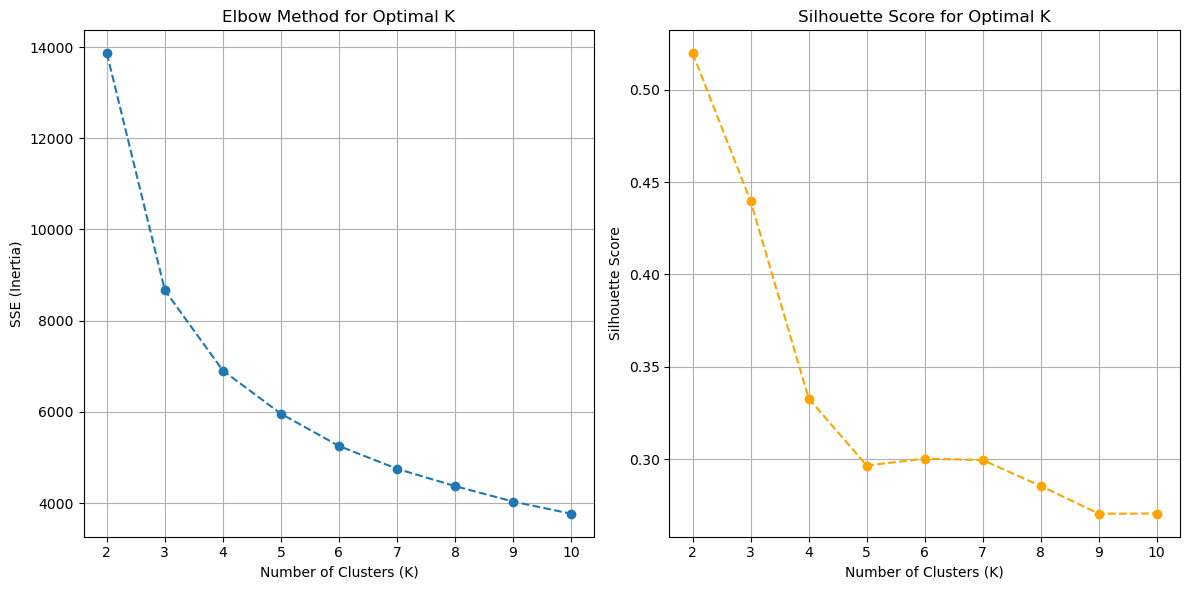


Trung bình các đặc trưng cho từng cụm:
          Dribbling  Finishing  Shot Power
Cluster                                  
0        52.997293  35.818354   56.918246
1        68.847104  62.668670   70.909865
2        22.068891  18.112400   28.202321

Số lượng cầu thủ trong mỗi cụm:
 Cluster
1    5991
0    3694
2    1379
Name: count, dtype: int64


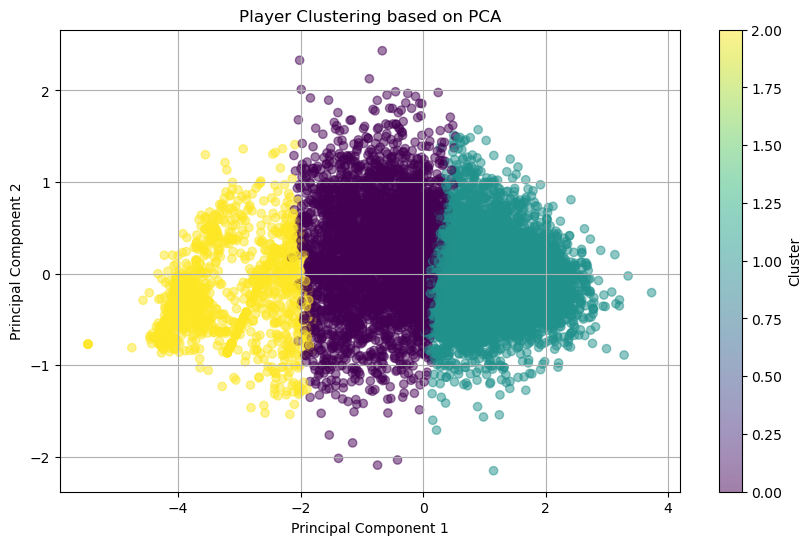

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assume df_player is a DataFrame that contains player data
df_player = player.copy()

# Select the necessary metrics
features = df_player[['Dribbling', 'Finishing', 'Shot Power']]

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to a DataFrame for easier handling
features_scaled_df = pd.DataFrame(features_scaled, columns=['Dribbling', 'Finishing', 'Shot Power'])

# Descriptive statistics
stats = features_scaled_df.describe()
print("Thống kê mô tả:\n", stats)

# Check the relationship between the metrics
correlation = features_scaled_df.corr()
print("\nMối quan hệ giữa các chỉ số:\n", correlation)

# Select the optimal number of clusters (K) using the Elbow method
sse = []  # Sum of Squared Errors
silhouette_scores = []  # Silhouette scores
k_range = range(2, 11)  # Experiment with K from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot the Elbow graph and Silhouette Score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(k_range)
plt.grid()

plt.tight_layout()
plt.show()

# Select the optimal number of clusters (k) - here I will choose k = 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_player['Cluster'] = kmeans.fit_predict(features_scaled)

# Perform PCA analysis to reduce dimensionality and visualize
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot the clustering graph
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                      c=df_player['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Player Clustering based on PCA')
plt.colorbar(scatter, label='Cluster')
plt.grid()

# Calculate the mean of the features for each cluster
cluster_means = df_player.groupby('Cluster')[['Dribbling', 'Finishing', 'Shot Power']].mean()
print("\nTrung bình các đặc trưng cho từng cụm:\n", cluster_means)

# Calculate the number of players in each cluster
cluster_counts = df_player['Cluster'].value_counts()
print("\nSố lượng cầu thủ trong mỗi cụm:\n", cluster_counts)

plt.show()


# Analyze player style and determine the optimal position

In [22]:
# Add a column for player style based on the clusters
def player_style(cluster):
    if cluster == 0:
        return 'Attacker'
    elif cluster == 1:
        return 'Midfielder'
    else:
        return 'Defender'

df_player['Playing Style'] = df_player['Cluster'].apply(player_style)

# XView the results
print(df_player[['Player Name', 'Dribbling', 'Finishing', 'Shot Power', 'Playing Style']])


             Player Name  Dribbling  Finishing  Shot Power Playing Style
0           Lionel Messi         96         93          80    Midfielder
1      Cristiano Ronaldo         93         95          94    Midfielder
2           Manuel Neuer         16         13          25      Defender
3                 Neymar         94         88          78    Midfielder
4            Luis Suarez         88         90          88    Midfielder
...                  ...        ...        ...         ...           ...
11059    Frederic Schaub         23         36          26      Defender
11060       Nacer Chadli          0          0           0      Defender
11061       Pavel Sultes          0          0           0      Defender
11062    Papy Djilobodji          0          0           0      Defender
11063        Eric Hassli          0          0           0      Defender

[11064 rows x 5 columns]
